In [1]:
%reload_ext autoreload
%autoreload 2
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats
from common import load_data, baseline_results_wc
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale


In [ ]:
# Data Loading
random_state = 1234
test_size = 0.40
pareto_cutoff = 0.5
rank_by_domination_count = True
system = "x264"

performances = []
# performances = ["fps", "cpu"]
# performances = ["kbs", "fps"]
# performances = ["kbs", "etime"]

(
    perf_matrix_initial,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(system=system, data_dir="../data", input_properties_type="tabular")

if len(performances) == 0:
    performances = all_performances

nmdf = (
    perf_matrix_initial[["inputname"] + performances]
    .groupby("inputname", as_index=True)
    # .transform(lambda x: scale(x))
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
nmdf["worst_case_performance"] = nmdf[performances].max(axis=1)
perf_matrix = pd.merge(
    perf_matrix_initial,
    nmdf,
    suffixes=("_raw", None),
    left_index=True,
    right_index=True,
)
perf_matrix["rank"] = perf_matrix.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort() + 1
)
# We adjust the WCP by expressing it as the difference from the best WCP, i.e. the best WCP is always 0
perf_matrix["worst_case_performance"] = (
    perf_matrix[["inputname", "worst_case_performance"]]
    .groupby("inputname", as_index=True)
    .transform(lambda x: x - x.min())
)

all_perf_raw = [f"{p}_raw" for p in performances]
all_perf_norm = [f"{p}" for p in performances]


# Split data
train_inp, test_inp = train_test_split(
    perf_matrix["inputname"].unique(),
    test_size=test_size,
    random_state=random_state,
)

# This is only to make our evaluation simpler
train_inp = sorted(train_inp)
test_inp = sorted(test_inp)

# Prepare baseline evaluation
icm = (
    perf_matrix[perf_matrix.inputname.isin(train_inp)][
        ["inputname", "configurationID", "worst_case_performance"]
    ]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: x.argsort() + 1
)
icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort() + 1
)


icm_test = (
    perf_matrix[~perf_matrix.inputname.isin(train_inp)][
        ["inputname", "configurationID", "worst_case_performance"]
    ]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_test["ranks"] = icm_test.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort() + 1
)

# Full dataset of input features + config features that are in the first rank
dataset_baselines = icm.join(config_features).join(input_features).reset_index()


def eval_prediction(pred_cfg_test):
    inp_pred_map = pd.DataFrame(
        zip(test_inp, pred_cfg_test), columns=["inputname", "configurationID"]
    )
    return icm_test.merge(inp_pred_map, on=["inputname", "configurationID"])[
        "worst_case_performance"
    ].mean()


/var/folders/rf/xz0f5yz96cb_qq_gcl42zqvw0000gn/T/ipykernel_14613/724685579.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_matrix["rank"] = perf_matrix.groupby("inputname", group_keys=False).apply(


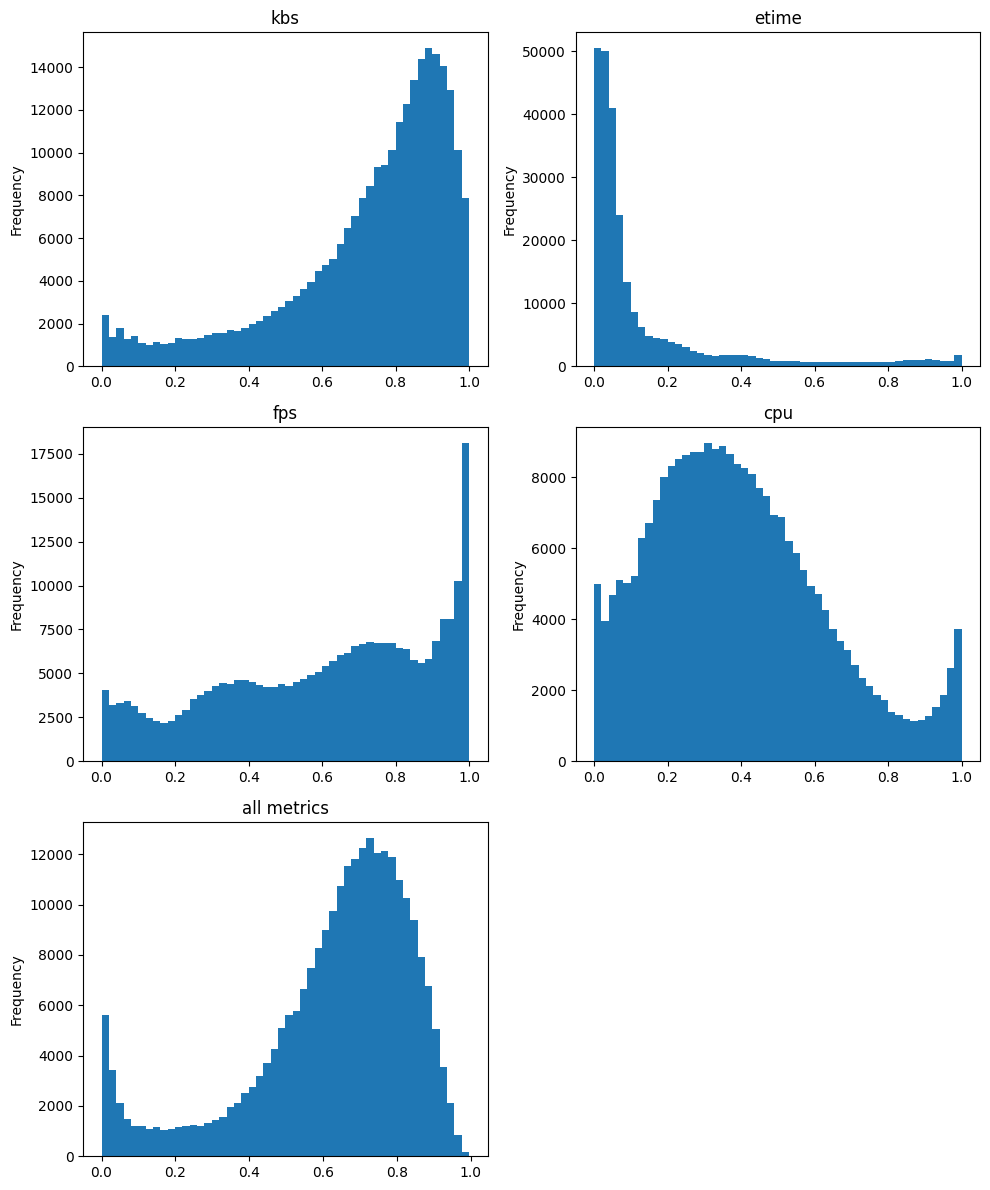

In [ ]:
# Calculate number of columns and rows needed
metrics = performances + ["worst_case_performance"]
n = len(metrics)
rows = int(np.ceil(n / 2))
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
axes = axes.flatten()

for i, c in enumerate(metrics):
    perf_matrix[c].plot.hist(bins=50, ax=axes[i])
    if c == "worst_case_performance":
        axes[i].set_title("all metrics")
    else:
        axes[i].set_title(c)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

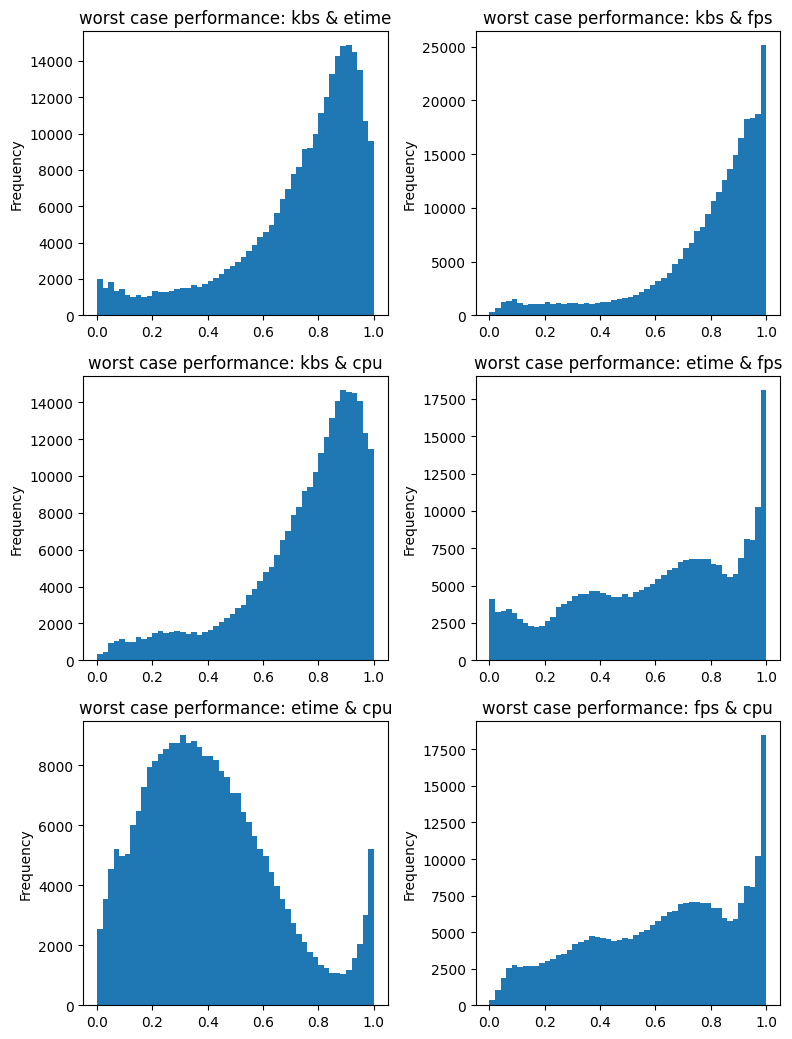

In [ ]:
# Calculate number of combinations for subplot grid
combs = list(itertools.combinations(performances, 2))
n = len(combs)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.5 * rows))
axes = axes.flatten()

for i, (c1, c2) in enumerate(combs):
    perf_matrix[[c1, c2]].max(axis=1).plot.hist(bins=50, ax=axes[i])
    axes[i].set_title(f"worst case performance: {c1} & {c2}")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# Baseline preparation


baseline_results_wc(
    icm, icm_ranked_measures, icm_test, dataset_baselines, config_features, verbose=True
)

Best WCP per input: 0.00+-0.00 (with 20 configs)
Average WCP per input: 0.62+-0.08
Average WCP of the overall best configuration: 0.05+-0.07
Average WCP of the most common configuration: 0.07+-0.12
Average WCP of the best configuration for all metrics: 0.79+-0.08


{'best_avg': np.float64(0.0),
 'best_std': np.float64(0.0),
 'best_max': np.float64(0.0),
 'best_num_configs': 20,
 'average_avg': np.float64(0.6243882170960702),
 'average_std': np.float64(0.0818491764909217),
 'average_max': np.float64(0.8463292177080317),
 'overall_avg': np.float64(0.0484491346164429),
 'overall_std': np.float64(0.07071517873061312),
 'overall_max': np.float64(0.5550840842376603),
 'metric_avg': np.float64(0.7942396370918567),
 'metric_std': np.float64(0.08428393146320412),
 'metric_max': np.float64(0.9768113145354271),
 'common_avg': np.float64(0.0736009966952686),
 'common_std': np.float64(0.1216937461420605),
 'common_max': np.float64(0.7592832848143783)}

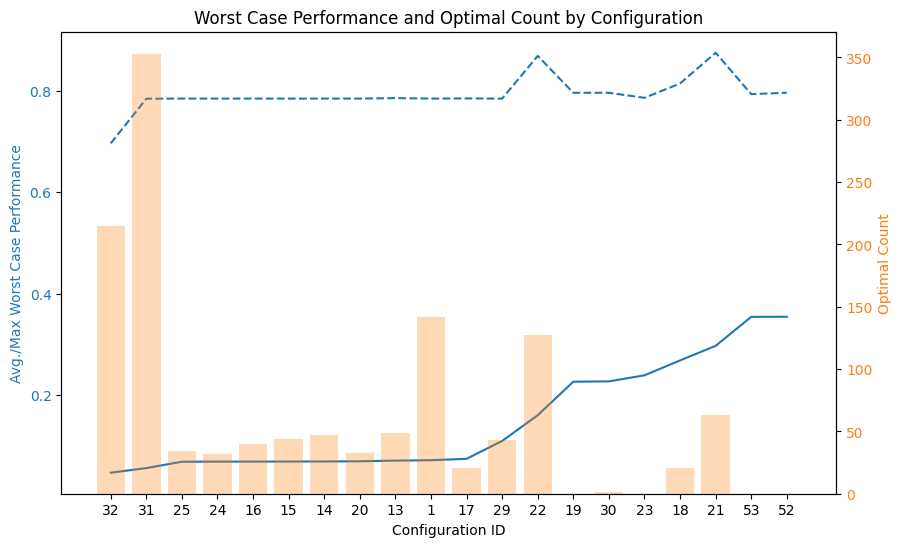

,configurationID,wcp_mean,wcp_max,optimal_count
0,32,0.046274,0.696382,215.0
1,31,0.055438,0.784553,353.0
2,25,0.067991,0.784792,34.0
3,24,0.068191,0.784792,32.0
4,16,0.068237,0.784792,40.0
5,15,0.068378,0.784792,44.0
6,14,0.068497,0.784792,47.0
7,20,0.068859,0.784792,33.0
8,13,0.070168,0.785704,49.0
9,1,0.070948,0.784792,142.0


In [ ]:
# Group by configurationID and calculate mean worst_case_performance across all inputs
# Also count how many times each config is the best for an input
best_counts = (
    perf_matrix.groupby("inputname")
    .apply(
        lambda x: x.loc[x["worst_case_performance"].idxmin(), "configurationID"],
        include_groups=False,
    )
    .value_counts()
    .to_frame("optimal_count")
    .reset_index()
    .rename(columns={"index": "configurationID"})
)

dataset = (
    perf_matrix.groupby("configurationID")
    .agg(
        wcp_mean=("worst_case_performance", "mean"),
        wcp_max=("worst_case_performance", "max"),
    )
    .sort_values("wcp_mean")
    .head(20)  # Select top 20 configurations with lowest average worst-case performance
    .reset_index()
    .merge(best_counts, on="configurationID", how="left")
    .fillna({"optimal_count": 0})
)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot worst case performance line
color = "tab:blue"
ax1.set_xlabel("Configuration ID")
ax1.set_ylabel("Avg./Max Worst Case Performance", color=color)
ax1.plot(range(len(dataset)), dataset.wcp_mean, color=color)
ax1.plot(range(len(dataset)), dataset.wcp_max, color=color, linestyle="--")
ax1.set_xticks(range(len(dataset)))
ax1.set_xticklabels(dataset.configurationID)
ax1.tick_params(axis="y", labelcolor=color)

# Create second y-axis and plot optimal count bars
ax2 = ax1.twinx()
color = "tab:orange"
ax2.set_ylabel("Optimal Count", color=color)
ax2.bar(range(len(dataset)), dataset.optimal_count, alpha=0.3, color=color)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Worst Case Performance and Optimal Count by Configuration")
plt.show()

dataset

In [90]:
cip = perf_matrix[["configurationID", "inputname", "worst_case_performance"]].pivot(
    index="configurationID", columns="inputname", values="worst_case_performance"
)
# Find all rows in cip where there is another row where all values are lower, i.e. it's dominated
dominated = np.array(
    [np.any([np.all(row2 < row1) for row2 in cip.values]) for row1 in cip.values]
)

# A dominated configuration can never be relevant, so we can remove it
non_dominated_configs = cip.index[~dominated]
print(f"Number of non-dominated configurations: {len(non_dominated_configs)}/{len(cip)}")
cip["wcp_mean"] = cip.mean(axis=1)
cip["wcp_max"] = cip.max(axis=1)
cip

Number of non-dominated configurations: 93/201


inputname,Animation_1080P-01b3,Animation_1080P-05f8,Animation_1080P-0c4f,Animation_1080P-0cdf,Animation_1080P-18f5,Animation_1080P-209f,Animation_1080P-21dd,Animation_1080P-2fbe,Animation_1080P-2fff,Animation_1080P-3d67,...,Vlog_720P-4e3d,Vlog_720P-5364,Vlog_720P-55b6,Vlog_720P-561e,Vlog_720P-5d08,Vlog_720P-60f8,Vlog_720P-6410,Vlog_720P-6d56,wcp_mean,wcp_max
configurationID,,,,,,,,,,,,,,,,,,,,,
1,0.784792,0.025869,0.028384,0.013590,0.027728,0.040229,0.005204,0.000168,0.019651,0.000084,...,0.053584,0.301789,0.002528,0.038139,0.016073,0.024616,0.196894,0.039579,0.070948,0.784792
2,0.825274,0.506253,0.654941,0.722473,0.599329,0.303477,0.342883,0.680178,0.562525,0.416060,...,0.574549,0.247151,0.724653,0.702210,0.561672,0.716244,0.242595,0.633700,0.521954,0.885673
3,0.853165,0.669414,0.851439,0.789053,0.852242,0.870893,0.784400,0.746856,0.584836,0.190312,...,0.624734,0.544844,0.801363,0.972494,0.553106,0.891579,0.607095,0.816129,0.749616,0.978119
4,0.846466,0.730496,0.838427,0.781769,0.789617,0.842887,0.795108,0.754999,0.582162,0.194498,...,0.620353,0.547750,0.776515,0.918532,0.540358,0.884608,0.614686,0.787055,0.738319,0.950089
5,0.848629,0.583466,0.822197,0.737751,0.721900,0.817744,0.722520,0.610662,0.535965,0.308138,...,0.587846,0.475198,0.751871,0.862012,0.510562,0.831322,0.619198,0.641843,0.675941,0.933048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.841993,0.903065,0.929788,0.892858,0.858213,0.901849,0.880169,0.898617,0.722212,0.506662,...,0.727602,0.704307,0.842407,0.966291,0.616491,0.920368,0.810065,0.808182,0.827944,0.986175
198,0.851224,0.878490,0.898780,0.881111,0.848882,0.863664,0.857912,0.885804,0.713644,0.507826,...,0.698990,0.693222,0.807859,0.949692,0.599857,0.908565,0.791450,0.798308,0.812088,0.960047
199,0.854928,0.906895,0.932732,0.895099,0.870493,0.910164,0.884354,0.903365,0.728542,0.524311,...,0.721313,0.710322,0.841261,0.976597,0.621030,0.924957,0.813913,0.813919,0.833742,0.985750


In [ ]:
cip_sorted = cip.loc[non_dominated_configs].sort_values("wcp_mean")
inputnames = perf_matrix["inputname"].unique()

best_performance = float("inf")
best_configs = None
max_configs = 2

selected_configs = [cip_sorted.index.tolist()[0]]


while True:
    print(selected_configs)

    remaining_configs = set(cip_sorted.index.tolist()) - set(selected_configs)

    # Pick next config
    while len(remaining_configs) > 0:
        next_selected_configs = selected_configs + [remaining_configs.pop()]

        next_perf = cip_sorted.loc[next_selected_configs].min(axis=0).mean() 

        if next_perf < best_performance:
            best_performance = next_perf
            best_configs = next_selected_configs

    selected_configs = best_configs

    # Aggregate a configuration set
    best_perf_per_input = cip_sorted[inputnames].loc[selected_configs].min(axis=0)

    # Current performance for mean WCP minimization
    current_perf = cip_sorted.loc[selected_configs].min(axis=0).mean() #.item() #.max(axis=0)
    # current_perf = cip_sorted.loc[selected_configs].min(axis=0).max()

    # Non-dominated configurations
    # cip_sorted[(cip_sorted[inputnames] <= best_perf_per_input).any(axis=1)]
    current_perf

[32]


0.046778188229794515

In [87]:
from sklearn.model_selection import KFold

splits = 3
kf_inp = KFold(n_splits=splits, random_state=random_state, shuffle=True)

inputnames = perf_matrix["inputname"].unique()

## Baselines
for split_idx, (train_inp_idx, test_inp_idx) in enumerate(kf_inp.split(inputnames)):
    train_inp = sorted(inputnames[train_inp_idx])
    test_inp = sorted(inputnames[test_inp_idx])
    cip2 = cip[train_inp]
    dominated = np.array(
    [np.any([np.all(row2 < row1) for row2 in cip2.values]) for row1 in cip2.values]
)

    # A dominated configuration can never be relevant, so we can remove it
    non_dominated_configs = cip2.index[~dominated]
    print(f"Number of non-dominated configurations: {len(non_dominated_configs)}/{len(cip2)}")

Number of non-dominated configurations: 88/201
Number of non-dominated configurations: 87/201
Number of non-dominated configurations: 79/201


In [ ]:
# For each input, find the worst case performance across n selected configurations
def get_worst_case_performance(selected_configs, perf_matrix):
    # Get performance matrix for just the selected configurations
    selected_perf = perf_matrix[perf_matrix.configurationID.isin(selected_configs)]

    # For each input, find the best (minimum) worst case performance among selected configs
    input_min_perf = selected_perf.groupby("inputname")["worst_case_performance"].min()

    # Return average and max across all inputs
    return input_min_perf.mean(), input_min_perf.max()


# Try different numbers of configurations
n_configs = range(1, 6)
results = []

for n in n_configs:
    # Get top n configurations by average worst case performance
    top_n = dataset.nsmallest(n, "wcp_mean")["configurationID"].values
    avg_worst, max_worst = get_worst_case_performance(top_n, perf_matrix)
    results.append(
        {
            "n_configs": n,
            "selected_configs": top_n,
            "avg_worst_case": avg_worst,
            "max_worst_case": max_worst,
        }
    )

# Print results
for r in results:
    print(f"\nNumber of configs: {r['n_configs']}")
    print(f"Selected configs: {r['selected_configs']}")
    print(f"Average worst case: {r['avg_worst_case']:.4f}")
    print(f"Max worst case: {r['max_worst_case']:.4f}")


Number of configs: 1
Selected configs: [32]
Average worst case: 0.0463
Max worst case: 0.6964

Number of configs: 2
Selected configs: [32 31]
Average worst case: 0.0308
Max worst case: 0.6964

Number of configs: 3
Selected configs: [32 31 25]
Average worst case: 0.0275
Max worst case: 0.6964

Number of configs: 4
Selected configs: [32 31 25 24]
Average worst case: 0.0258
Max worst case: 0.6964

Number of configs: 5
Selected configs: [32 31 25 24 16]
Average worst case: 0.0242
Max worst case: 0.6964


In [ ]:
# Try different numbers of configurations
n_configs = range(1, 31)
results = []

selected_configs = []
for n in n_configs:
    # If this is the first iteration, start with best single config
    if n == 1:
        best_config = dataset.nsmallest(1, "wcp_mean")[
            "configurationID"
        ].values.tolist()[0]
        selected_configs = [best_config]
        prev_avg_worst = float("inf")
    else:
        # Try adding each remaining config to our current set
        remaining_configs = set(dataset["configurationID"].values.tolist()) - set(
            selected_configs
        )
        best_avg = float("inf")
        best_config = None

        for config in remaining_configs:
            test_configs = selected_configs + [config]
            avg_worst, max_worst = get_worst_case_performance(test_configs, perf_matrix)

            if avg_worst < best_avg:
                best_avg = avg_worst
                best_max = max_worst
                best_config = config

        # Stop if no improvement
        if best_avg >= prev_avg_worst:
            break

        selected_configs.append(best_config)
        prev_avg_worst = best_avg

    # Calculate final scores for this iteration
    avg_worst, max_worst = get_worst_case_performance(selected_configs, perf_matrix)
    results.append(
        {
            "n_configs": n,
            "selected_configs": selected_configs.copy(),
            "avg_worst_case": avg_worst,
            "max_worst_case": max_worst,
        }
    )

# Print results
for r in results:
    print(f"\nNumber of configs: {r['n_configs']}")
    print(f"Selected configs: {r['selected_configs']}")
    print(f"Average worst case: {r['avg_worst_case']:.4f}")
    print(f"Max worst case: {r['max_worst_case']:.4f}")


Number of configs: 1
Selected configs: [32]
Average worst case: 0.0463
Max worst case: 0.6964

Number of configs: 2
Selected configs: [32, 22]
Average worst case: 0.0280
Max worst case: 0.6964

Number of configs: 3
Selected configs: [32, 22, 31]
Average worst case: 0.0161
Max worst case: 0.6964

Number of configs: 4
Selected configs: [32, 22, 31, 1]
Average worst case: 0.0103
Max worst case: 0.6964

Number of configs: 5
Selected configs: [32, 22, 31, 1, 21]
Average worst case: 0.0068
Max worst case: 0.6964

Number of configs: 6
Selected configs: [32, 22, 31, 1, 21, 13]
Average worst case: 0.0054
Max worst case: 0.6964

Number of configs: 7
Selected configs: [32, 22, 31, 1, 21, 13, 16]
Average worst case: 0.0047
Max worst case: 0.6964

Number of configs: 8
Selected configs: [32, 22, 31, 1, 21, 13, 16, 18]
Average worst case: 0.0040
Max worst case: 0.6964

Number of configs: 9
Selected configs: [32, 22, 31, 1, 21, 13, 16, 18, 29]
Average worst case: 0.0034
Max worst case: 0.6964

Number

In [58]:
from itertools import combinations
from tqdm import tqdm
import numpy as np

results = []
n_configs = range(1, 11)

# Pre-filter configs to only include those that are optimal for at least one input
all_configs = dataset["configurationID"].values.tolist()

for n in tqdm(n_configs):
    best_avg_worst = float("inf")
    best_max_worst = float("inf")
    avg_best_combo = None
    max_best_combo = None

    # Create all combinations
    combos = list(combinations(all_configs, n))

    # Evaluate combinations sequentially
    for combo in combos:
        avg_worst, max_worst = get_worst_case_performance(combo, perf_matrix)

        if avg_worst < best_avg_worst:
            best_avg_worst = avg_worst
            avg_best_avg_worst = avg_worst
            avg_best_max_worst = max_worst
            avg_best_combo = combo

        if max_worst < best_max_worst:
            best_max_worst = max_worst
            max_best_avg_worst = avg_worst
            max_best_max_worst = max_worst
            max_best_combo = combo

    results.append(
        {
            "n_configs": n,
            "selected_configs_avg": avg_best_combo,
            "avg_best_avg_worst_case": avg_best_avg_worst,
            "avg_best_max_worst_case": avg_best_max_worst,
            "selected_configs_max": max_best_combo,
            "max_best_avg_worst_case": max_best_avg_worst,
            "max_best_max_worst_case": max_best_max_worst,
        }
    )

# Print results
for r in results:
    print(f"\nNumber of configs: {r['n_configs']}")
    print(f"Selected configs avg: {r['selected_configs_avg']}")
    print(
        f"Average worst case avg: {r['avg_best_avg_worst_case']:.4f} | {r['avg_best_max_worst_case']:.4f}"
    )
    print(f"Selected configs max: {r['selected_configs_max']}")
    print(
        f"Average worst case max: {r['max_best_avg_worst_case']:.4f} | {r['max_best_max_worst_case']:.4f}"
    )

 80%|████████  | 8/10 [18:37<04:39, 139.73s/it]


KeyboardInterrupt: 

In [59]:
for r in results:
    print(f"\nNumber of configs: {r['n_configs']}")
    print(f"Selected configs avg: {r['selected_configs_avg']}")
    print(
        f"Average worst case avg: {r['avg_best_avg_worst_case']:.4f} | {r['avg_best_max_worst_case']:.4f}"
    )
    print(f"Selected configs max: {r['selected_configs_max']}")
    print(
        f"Average worst case max: {r['max_best_avg_worst_case']:.4f} | {r['max_best_max_worst_case']:.4f}"
    )


Number of configs: 1
Selected configs avg: (32,)
Average worst case avg: 0.0463 | 0.6964
Selected configs max: (32,)
Average worst case max: 0.0463 | 0.6964

Number of configs: 2
Selected configs avg: (32, 22)
Average worst case avg: 0.0280 | 0.6964
Selected configs max: (32, 53)
Average worst case max: 0.0452 | 0.5551

Number of configs: 3
Selected configs avg: (32, 31, 22)
Average worst case avg: 0.0161 | 0.6964
Selected configs max: (32, 22, 53)
Average worst case max: 0.0276 | 0.4479

Number of configs: 4
Selected configs avg: (32, 31, 1, 22)
Average worst case avg: 0.0103 | 0.6964
Selected configs max: (32, 31, 22, 53)
Average worst case max: 0.0157 | 0.4479

Number of configs: 5
Selected configs avg: (32, 31, 1, 22, 21)
Average worst case avg: 0.0068 | 0.6964
Selected configs max: (32, 31, 25, 22, 53)
Average worst case max: 0.0129 | 0.4479

Number of configs: 6
Selected configs avg: (32, 31, 13, 1, 22, 21)
Average worst case avg: 0.0054 | 0.6964
Selected configs max: (32, 31, 2

shapes (772, 50) (772,) (515, 50) (515,)


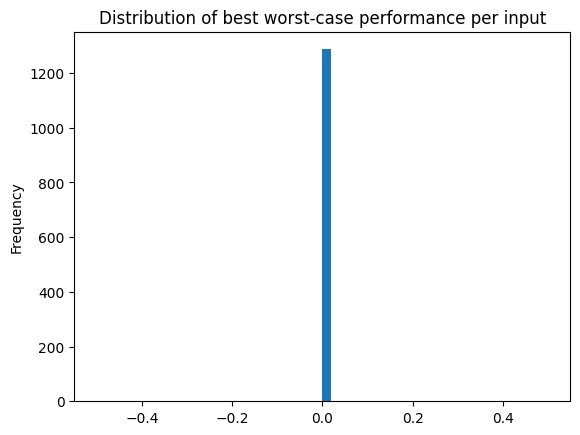

In [ ]:
# Single configuration dataset
# We find the best configuration per input
dataset = (
    perf_matrix.groupby("inputname")
    .apply(lambda x: x.loc[x["worst_case_performance"].idxmin()], include_groups=False)
    .reset_index()
)

train_perf = dataset[dataset.inputname.isin(train_inp)].copy()
test_perf = dataset[dataset.inputname.isin(test_inp)]

X = input_preprocessor.fit_transform(train_perf[input_features.columns])
y = train_perf["configurationID"]

X_test = input_preprocessor.transform(test_perf[input_features.columns])
y_test = test_perf["configurationID"]
print("shapes", X.shape, y.shape, X_test.shape, y_test.shape)

# This is the best worst-case performance per input
dataset.worst_case_performance.plot.hist(bins=50)
plt.title("Distribution of best worst-case performance per input")
plt.show()

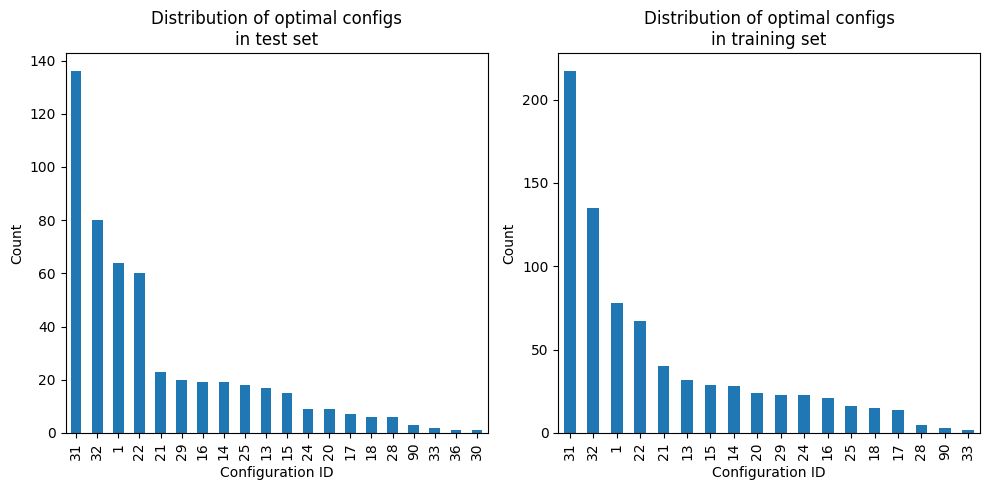

In [7]:
# Count how often each configuration in training set is optimal for test inputs
test_best_configs = test_perf["configurationID"].value_counts()
train_best_configs = train_perf["configurationID"].value_counts()

plt.figure(figsize=(10, 5))
plt.subplot(121)
test_best_configs.plot.bar()
plt.title("Distribution of optimal configs\nin test set")
plt.xlabel("Configuration ID")
plt.ylabel("Count")

plt.subplot(122)
train_best_configs.plot.bar()
plt.title("Distribution of optimal configs\nin training set")
plt.xlabel("Configuration ID")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [12]:
# Analysis: Are the best configurations in our labels?

from sklearn.model_selection import KFold

splits = 5
kf_inp = KFold(n_splits=splits, random_state=random_state, shuffle=True)

inputnames = perf_matrix["inputname"].unique()

## Baselines
for split_idx, (train_inp_idx, test_inp_idx) in enumerate(kf_inp.split(inputnames)):
    train_inp = sorted(inputnames[train_inp_idx])
    test_inp = sorted(inputnames[test_inp_idx])
    train_perf = dataset[dataset.inputname.isin(train_inp)]
    test_perf = dataset[dataset.inputname.isin(test_inp)]

    best_cfg_id_overall = (  # noqa: F841
        train_perf[["configurationID", "worst_case_performance"]]
        .groupby("configurationID")
        .mean()
        .idxmin()
        .item()
    )

    test_best_configs = test_perf["configurationID"].value_counts()
    train_best_configs = train_perf["configurationID"].value_counts()
    # This is for how many test inputs we do not have the best configuration in the training set
    missing_configs = test_best_configs[
        list(
            set(test_perf["configurationID"].unique())
            - set(train_perf["configurationID"].unique())
        )
    ].sum()
    print(
        f"Split {split_idx}: Missing best configurations in training set: {missing_configs}/{len(test_perf['configurationID'].unique())}"
    )

Split 0: Missing best configurations in training set: 2/20
Split 1: Missing best configurations in training set: 0/17
Split 2: Missing best configurations in training set: 0/17
Split 3: Missing best configurations in training set: 0/17
Split 4: Missing best configurations in training set: 0/16


In [13]:
clf = DecisionTreeClassifier(max_depth=8)
X_all = np.concatenate((X, X_test, X_test))
y_all = np.concatenate((y, y_test, y_test))
# y_all[-10:] += 1
clf.fit(X_all, y_all)
clf.score(X_test, y_test)


0.629126213592233

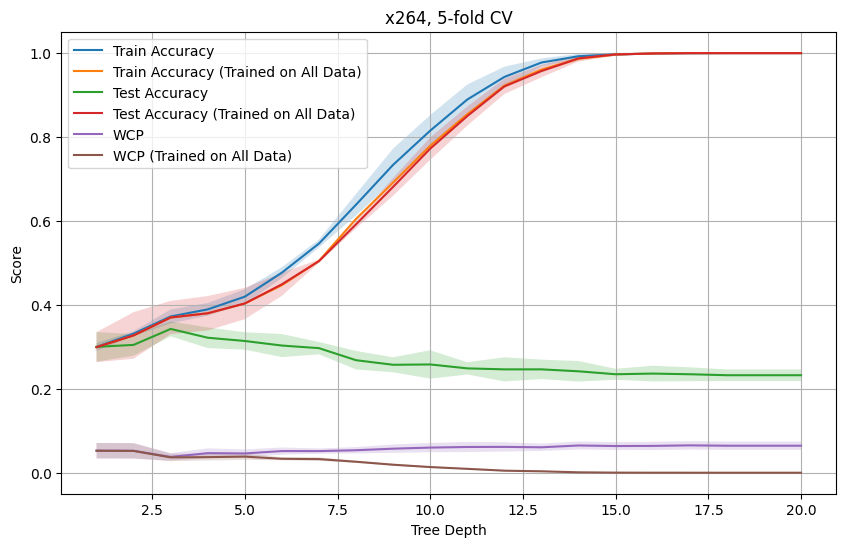

In [26]:
# Analysis: Are the best configurations in our labels?

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

splits = 5
kf_inp = KFold(n_splits=splits, random_state=None, shuffle=False)

inputnames = perf_matrix["inputname"].unique()

# Store results for all splits
all_train_acc = []
all_train_acc2 = []
all_test_acc = []
all_test_acc2 = []
all_wcp = []
all_wcp2 = []

## Baselines
for split_idx, (train_inp_idx, test_inp_idx) in enumerate(kf_inp.split(inputnames)):
    train_inp = sorted(inputnames[train_inp_idx])
    test_inp = sorted(inputnames[test_inp_idx])
    train_perf = dataset[dataset.inputname.isin(train_inp)]
    test_perf = dataset[dataset.inputname.isin(test_inp)]

    def eval_prediction(pred_cfg_test):
        inp_pred_map = pd.DataFrame(
            zip(test_inp, pred_cfg_test), columns=["inputname", "configurationID"]
        )
        return perf_matrix.merge(inp_pred_map, on=["inputname", "configurationID"])[
            "worst_case_performance"
        ].mean()

    target_preprocessor = LabelEncoder()
    target_preprocessor.fit(dataset["configurationID"])

    X = input_preprocessor.fit_transform(train_perf[input_features.columns])
    y = target_preprocessor.transform(train_perf["configurationID"])

    X_test = input_preprocessor.transform(test_perf[input_features.columns])
    y_test = target_preprocessor.transform(test_perf["configurationID"])

    X_all = np.concatenate((X, X_test))
    y_all = np.concatenate((y, y_test))

    depths = range(1, 21)  # X_all.shape[1]+1)
    train_acc = []
    train_acc2 = []
    test_acc = []
    test_acc2 = []
    wcp = []
    wcp2 = []

    for md in depths:
        clf = DecisionTreeClassifier(
            criterion="entropy", max_depth=md, random_state=random_state
        )
        clf = clf.fit(X, y)
        pred_cfg_test = target_preprocessor.inverse_transform(clf.predict(X_test))

        clf2 = DecisionTreeClassifier(
            criterion="entropy", max_depth=md, random_state=random_state
        )
        clf2 = clf2.fit(X_all, y_all)
        pred_cfg_test2 = target_preprocessor.inverse_transform(clf2.predict(X_test))

        train_acc.append(clf.score(X, y))
        train_acc2.append(clf2.score(X_all, y_all))
        test_acc.append(clf.score(X_test, y_test))
        test_acc2.append(clf2.score(X_test, y_test))
        wcp.append(eval_prediction(pred_cfg_test))
        wcp2.append(eval_prediction(pred_cfg_test2))

    all_train_acc.append(train_acc)
    all_train_acc2.append(train_acc2)
    all_test_acc.append(test_acc)
    all_test_acc2.append(test_acc2)
    all_wcp.append(wcp)
    all_wcp2.append(wcp2)

mean_train_acc = np.mean(all_train_acc, axis=0)
std_train_acc = np.std(all_train_acc, axis=0)
mean_train_acc2 = np.mean(all_train_acc2, axis=0)
std_train_acc2 = np.std(all_train_acc2, axis=0)
mean_test_acc = np.mean(all_test_acc, axis=0)
std_test_acc = np.std(all_test_acc, axis=0)
mean_test_acc2 = np.mean(all_test_acc2, axis=0)
std_test_acc2 = np.std(all_test_acc2, axis=0)
mean_wcp = np.mean(all_wcp, axis=0)
std_wcp = np.std(all_wcp, axis=0)
mean_wcp2 = np.mean(all_wcp2, axis=0)
std_wcp2 = np.std(all_wcp2, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(depths, mean_train_acc, label="Train Accuracy")
plt.fill_between(
    depths, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, alpha=0.2
)
plt.plot(depths, mean_train_acc2, label="Train Accuracy (Trained on All Data)")
plt.fill_between(
    depths,
    mean_train_acc2 - std_train_acc2,
    mean_train_acc2 + std_train_acc2,
    alpha=0.2,
)
plt.plot(depths, mean_test_acc, label="Test Accuracy")
plt.fill_between(
    depths, mean_test_acc - std_test_acc, mean_test_acc + std_test_acc, alpha=0.2
)
plt.plot(depths, mean_test_acc2, label="Test Accuracy (Trained on All Data)")
plt.fill_between(
    depths, mean_test_acc2 - std_test_acc2, mean_test_acc2 + std_test_acc2, alpha=0.2
)
plt.plot(depths, mean_wcp, label="WCP")
plt.fill_between(depths, mean_wcp - std_wcp, mean_wcp + std_wcp, alpha=0.2)
plt.plot(depths, mean_wcp2, label="WCP (Trained on All Data)")
plt.fill_between(depths, mean_wcp2 - std_wcp2, mean_wcp2 + std_wcp2, alpha=0.2)
plt.xlabel("Tree Depth")
plt.ylabel("Score")
plt.legend()
plt.title("x264, 5-fold CV")
plt.grid(True)
plt.show()


In [7]:
clf = RandomForestClassifier(n_estimators=10, random_state=random_state)
clf.fit(X, y)
print("scores", clf.score(X, y), clf.score(X_test, y_test))
pred_cfg_test = clf.predict(X_test)

print(f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}")
print(classification_report(y_test, clf.predict(X_test)))


scores 0.9857512953367875 0.10485436893203884
Avg. WCP on test inputs 0.04
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
          11       0.00      0.00      0.00         4
          13       0.21      0.28      0.24        78
          14       0.06      0.09      0.07        47
          15       0.13      0.09      0.11        66
          16       0.04      0.06      0.05        32
          17       0.12      0.18      0.14        34
          18       0.00      0.00      0.00         8
          19       0.15      0.13      0.14        15
          20       0.13      0.16      0.14        43
          22       0.00      0.00      0.00         9
          23       0.00      0.00      0.00         8
          24       0.00      0.00      0.00        35
          25       0.08      0.04      0.06        23
          28       0.00      0.00      0.00         7
          29       0.00      0.00      0.00         3
      

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [8]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    hidden_layer_sizes=(
        8,
        8,
        8,
    ),
    max_iter=1000,
    random_state=random_state,
)
clf.fit(X, y)
print("scores", clf.score(X, y), clf.score(X_test, y_test))
pred_cfg_test = clf.predict(X_test)

print(f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}")
print(classification_report(y_test, clf.predict(X_test)))


scores 0.13730569948186527 0.1378640776699029
Avg. WCP on test inputs 0.03
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
          11       0.00      0.00      0.00         4
          13       0.17      0.77      0.28        78
          14       0.09      0.02      0.03        47
          15       0.19      0.06      0.09        66
          16       0.00      0.00      0.00        32
          17       0.00      0.00      0.00        34
          18       0.00      0.00      0.00         8
          19       0.00      0.00      0.00        15
          20       0.05      0.14      0.07        43
          22       0.00      0.00      0.00         9
          23       0.00      0.00      0.00         8
          24       0.00      0.00      0.00        35
          25       0.00      0.00      0.00        23
          28       0.00      0.00      0.00         7
          29       0.00      0.00      0.00         3
      

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

clf = LogisticRegression(max_iter=1_000, dual=True, solver="liblinear")

scaler = StandardScaler()
X2 = scaler.fit_transform(X)
X_test2 = scaler.transform(X_test)
clf.fit(X2, y)
print("scores", clf.score(X2, y), clf.score(X_test2, y_test))
pred_cfg_test = clf.predict(X_test2)

print(f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}")
print(classification_report(y_test, clf.predict(X_test2)))


scores 0.39248704663212436 0.34951456310679613
Avg. WCP on test inputs 0.04
              precision    recall  f1-score   support

           1       0.39      0.23      0.29        64
          13       0.33      0.06      0.10        17
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00        15
          16       1.00      0.05      0.10        19
          17       0.00      0.00      0.00         7
          18       0.00      0.00      0.00         6
          20       0.00      0.00      0.00         9
          21       0.54      0.30      0.39        23
          22       0.36      0.23      0.28        60
          24       0.00      0.00      0.00         9
          25       0.00      0.00      0.00        18
          28       0.00      0.00      0.00         6
          29       0.00      0.00      0.00        20
          30       0.00      0.00      0.00         1
          31       0.37      0.75      0.49       136
     

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=random_state)
clf.fit(X, y)
pred_cfg_test = clf.predict(X_test)
print(clf.score(X, y), clf.score(X_test, y_test))
print("Avg. WCP", eval_prediction(pred_cfg_test))
print(classification_report(y_test, clf.predict(X_test)))

1.0 0.09514563106796116
Avg. WCP 0.04629849170309152
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
          11       0.00      0.00      0.00         4
          13       0.25      0.18      0.21        78
          14       0.06      0.06      0.06        47
          15       0.10      0.08      0.08        66
          16       0.14      0.16      0.15        32
          17       0.08      0.15      0.11        34
          18       0.00      0.00      0.00         8
          19       0.00      0.00      0.00        15
          20       0.07      0.09      0.08        43
          22       0.00      0.00      0.00         9
          23       0.20      0.25      0.22         8
          24       0.11      0.14      0.12        35
          25       0.04      0.04      0.04        23
          28       0.00      0.00      0.00         7
          29       0.00      0.00      0.00         3
          30       0.00     

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [10]:
for depth in range(1, 20):
    clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
    clf.fit(X, y)
    pred_cfg_test = clf.predict(X_test)
    print(f"WCP@{depth}: {eval_prediction(pred_cfg_test):.3f}")

WCP@1: 0.029
WCP@2: 0.029
WCP@3: 0.031
WCP@4: 0.031
WCP@5: 0.030
WCP@6: 0.030
WCP@7: 0.030
WCP@8: 0.030
WCP@9: 0.035
WCP@10: 0.037
WCP@11: 0.036
WCP@12: 0.037
WCP@13: 0.040
WCP@14: 0.052
WCP@15: 0.053
WCP@16: 0.051
WCP@17: 0.048
WCP@18: 0.047
WCP@19: 0.048


In [11]:
clf2 = DecisionTreeClassifier(random_state=random_state, max_depth=None)
clf2.fit(X, y)

pred_cfg_test = clf2.predict(X)
print(f"WCP: {eval_prediction(pred_cfg_test):.3f}", clf2.score(X, y))
print(classification_report(y, clf2.predict(X)))

pred_cfg_test = clf2.predict(X_test)
print(f"WCP: {eval_prediction(pred_cfg_test):.3f}", clf2.score(X_test, y_test))
print(classification_report(y_test, clf2.predict(X_test)))

WCP: 0.042 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        32
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00        92
          14       1.00      1.00      1.00        73
          15       1.00      1.00      1.00        74
          16       1.00      1.00      1.00        72
          17       1.00      1.00      1.00        68
          18       1.00      1.00      1.00         6
          19       1.00      1.00      1.00        27
          20       1.00      1.00      1.00        74
          22       1.00      1.00      1.00         9
          23       1.00      1.00      1.00         9
          24       1.00      1.00      1.00        57
          25       1.00      1.00      1.00        49
          28       1.00      1.00      1.00         2
          29       1.00      1.00      1.00         1
          30

/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/helge/src/resist/partial-configuration/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

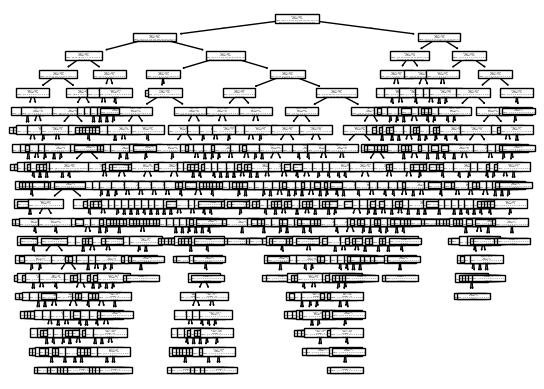

In [13]:
from sklearn import tree

tree.plot_tree(clf)
plt.show()


In [109]:
## Multiple configurations per input

# The threshold must be at least this high to include all inputs
# min_wc_perf_threshold = perf_matrix[["inputname", "worst_case_performance"]].groupby("inputname").min().max().item()
# wc_perf_threshold = 0.30


# worse_inputs = perf_matrix[perf_matrix["worst_case_performance"] >= wc_perf_threshold]["inputname"]
# # TODO Fix such that for missing inputs, we take the next best configuration (even if it's above the threshold)

# assert wc_perf_threshold >= min_wc_perf_threshold, "wc_perf_threshold not high enough"

# TODO We don't need this encoder, but we need something for the apply function in the dataset_below groupby
enc = LabelEncoder()
enc.fit(perf_matrix["configurationID"].tolist())

# This is the largest minimal WCP over all inputs
# If we set a general threshold it must be at least this high, otherwise we exclude inputs
min_wc_perf_threshold = (
    perf_matrix[["inputname", "worst_case_performance"]]
    .groupby("inputname")
    .min()
    .max()
    .item()
)
wc_perf_threshold = 0.03

is_below_threshold = perf_matrix[
    perf_matrix["worst_case_performance"] < wc_perf_threshold
].inputname.unique()
all_above_threshold = set(
    perf_matrix[
        perf_matrix["worst_case_performance"] >= wc_perf_threshold
    ].inputname.unique()
) - set(is_below_threshold)

# We find the best configurations per input
labels_below = (
    perf_matrix[perf_matrix["worst_case_performance"] < wc_perf_threshold]
    .groupby("inputname")["configurationID"]
    .apply(enc.transform)
)
labels_above = (
    perf_matrix[perf_matrix.inputname.isin(all_above_threshold)]
    .groupby("inputname")
    .apply(lambda x: x.loc[x["worst_case_performance"].idxmin()], include_groups=False)[
        "configurationID"
    ]
    .apply(lambda x: [x])
)

# (index/inputname, configurationIDs)
input_labels = pd.concat((labels_above, labels_below)).sort_index().reset_index()

dataset = input_labels.join(input_features, on="inputname").set_index(
    "inputname"
)  # .drop(columns=["configurationID"])

train_perf = dataset[dataset.index.isin(train_inp)].copy()
test_perf = dataset[dataset.index.isin(test_inp)]

<Axes: ylabel='Frequency'>

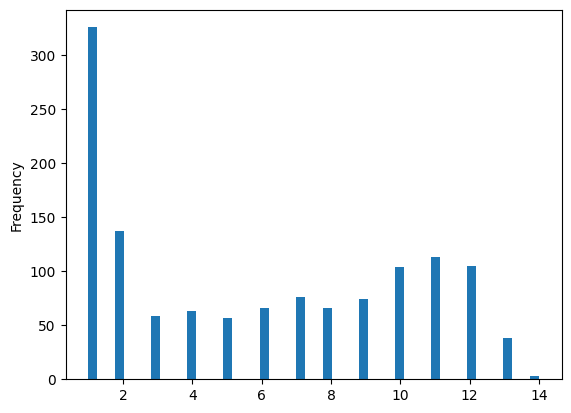

In [110]:
grouped_df = dataset
grouped_df["configurationID"].apply(len).plot.hist(bins=50)

In [113]:
# input_features_with_cfgs = grouped_df.join(input_features, on="inputname")

train_mask = dataset.index.isin(train_inp)

X_train = input_preprocessor.fit_transform(dataset[train_mask][input_features.columns])
X_test = input_preprocessor.transform(dataset[~train_mask][input_features.columns])

In [115]:
from common import DecisionTreeClassifierWithMultipleLabels

mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(grouped_df["configurationID"])

# Create a new DataFrame with the binary matrix
binary_df = pd.DataFrame(binary_matrix, columns=mlb.classes_, index=dataset.index)
y_train = binary_df.values[train_mask]
y_test = binary_df.values[~train_mask]

# cross

clf = DecisionTreeClassifierWithMultipleLabels(max_depth=X.shape[1])
clf.fit(X_train, y_train)
print("scores", clf.score(X_train, y_train), clf.score(X_test, y_test))
pred_cfg_test = enc.inverse_transform(clf.predict(X_test)).astype(int)
print(f"WCP {eval_prediction(pred_cfg_test)}")

scores 1.0 0.5252918287937743
WCP 0.3572387250105612


In [118]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {
    "max_depth": range(1, X.shape[1] + 1),
    # "criterion": ["entropy", "gini"],
}
clf = DecisionTreeClassifierWithMultipleLabels()

clf = GridSearchCV(
    clf,
    parameter_grid,
    cv=KFold(n_splits=4, random_state=random_state, shuffle=True),
    n_jobs=-1,
    refit=True,
)
clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=1234, shuffle=True),
             estimator=DecisionTreeClassifierWithMultipleLabels(), n_jobs=-1,
             param_grid={'max_depth': range(1, 20)})

In [121]:
print("scores", clf.score(X_train, y_train), clf.score(X_test, y_test))
pred_cfg_test = enc.inverse_transform(clf.predict(X_test)).astype(int)
print(f"WCP {eval_prediction(pred_cfg_test)}")

scores 0.6815533980582524 0.5836575875486382
WCP 0.1940595923251347


In [17]:
# TODO Evaluate decision tree size: it should be smaller for a larger wcp threshold
# TODO Change decision tree training to optimize
# TODO What's the best performance the configurations from the training set can achieve? / helps our internal evaluation of the method
# TODO How many configurations with very similar WCPs are there for the different inputs? -> make plot? heatmap, x input, y intensity per WCP bin
# TODO Statistical test vs best result (or all others?) / is it significantly higher?
# TODO Should we express the WCP as a percentage of the best WCP, e.g. MAPE over best possible WCP? That is, normalize WCP per input.

In [117]:
perf_matrix.groupby("inputname")["worst_case_performance"].agg(
    lambda x: (x < 0.05).sum()
).max()

18

In [20]:
import itertools

ap = []
for num_p in range(1, len(all_performances) + 1):
    ap.extend(list(map(list, itertools.combinations(all_performances, num_p))))

ap

[['kbs'],
 ['etime'],
 ['fps'],
 ['cpu'],
 ['kbs', 'etime'],
 ['kbs', 'fps'],
 ['kbs', 'cpu'],
 ['etime', 'fps'],
 ['etime', 'cpu'],
 ['fps', 'cpu'],
 ['kbs', 'etime', 'fps'],
 ['kbs', 'etime', 'cpu'],
 ['kbs', 'fps', 'cpu'],
 ['etime', 'fps', 'cpu'],
 ['kbs', 'etime', 'fps', 'cpu']]